In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('ts.csv')
data.head()

,DATE,IN_FOR,OUT_FOR,IN_KZT,OUT_KZT
0,1/1/2016,0.0,122953.0,1899647.0,1584705.0
1,1/2/2016,2942.0,115059.0,2706416.0,2315761.0
2,1/3/2016,263.0,147905.0,3548855.0,2971268.0
3,1/4/2016,13533594.0,9363025.0,23528654.0,11716898.0
4,1/5/2016,36769881.0,32769452.0,37289979.0,22565273.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
DATE       731 non-null object
IN_FOR     731 non-null float64
OUT_FOR    731 non-null float64
IN_KZT     731 non-null float64
OUT_KZT    731 non-null float64
dtypes: float64(4), object(1)
memory usage: 28.6+ KB


In [4]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


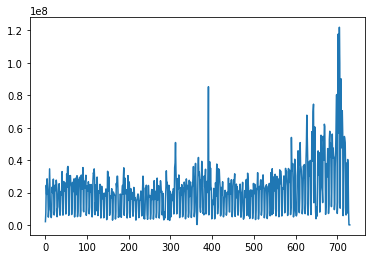

list index out of range


In [5]:
data0 = data[::-1]
data1 = data0.ix[:, 'OUT_FOR'].tolist()

# Uncomment below to use price change time series
# data1 = data0.ix[:, 'IN_FOR'].pct_change().dropna().tolist()

plt.plot(data1)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data1), STEP): 
    try:
        x_i = data1[i:i+WINDOW]
        y_i = data1[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [6]:
model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.35))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('linear'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="out_for.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='mean_squared_error',
              metrics=['acc'])

In [7]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 110, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 626 samples, validate on 70 samples
Epoch 1/110
626/626 [==============================] - 1s 2ms/step - loss: 79.3067 - acc: 0.5208 - val_loss: 37.6970 - val_acc: 0.5571

Epoch 00001: val_loss improved from inf to 37.69695, saving model to out_for.hdf5
Epoch 2/110
626/626 [==============================] - 0s 39us/step - loss: 72.0324 - acc: 0.5096 - val_loss: 34.9483 - val_acc: 0.5571

Epoch 00002: val_loss improved from 37.69695 to 34.94829, saving model to out_for.hdf5
Epoch 3/110
626/626 [==============================] - 0s 44us/step - loss: 65.7082 - acc: 0.4952 - val_loss: 32.3839 - val_acc: 0.5571

Epoch 00003: val_loss improved from 34.94829 to 32.38393, saving model to out_for.hdf5
Epoch 4/110
626/626 [==============================] - 0s 36us/step - loss: 60.4232 - acc: 0.5415 - val_loss: 30.0365 - val_acc: 0.5429

Epoch 00004: val_loss improved from 32.38393 to 30.03653, saving model to out_for.hdf5
Epoch 5/110
626/626 [==============================] - 0s 39us/st

626/626 [==============================] - 0s 35us/step - loss: 10.8205 - acc: 0.5990 - val_loss: 6.4331 - val_acc: 0.6286

Epoch 00037: val_loss improved from 6.63179 to 6.43310, saving model to out_for.hdf5
Epoch 38/110
626/626 [==============================] - 0s 28us/step - loss: 10.3847 - acc: 0.5958 - val_loss: 6.2399 - val_acc: 0.6429

Epoch 00038: val_loss improved from 6.43310 to 6.23995, saving model to out_for.hdf5
Epoch 39/110
626/626 [==============================] - 0s 40us/step - loss: 10.1396 - acc: 0.6022 - val_loss: 6.0554 - val_acc: 0.6571

Epoch 00039: val_loss improved from 6.23995 to 6.05535, saving model to out_for.hdf5
Epoch 40/110
626/626 [==============================] - 0s 37us/step - loss: 9.8012 - acc: 0.6054 - val_loss: 5.8741 - val_acc: 0.6714

Epoch 00040: val_loss improved from 6.05535 to 5.87409, saving model to out_for.hdf5
Epoch 41/110
626/626 [==============================] - 0s 28us/step - loss: 9.5044 - acc: 0.6390 - val_loss: 5.7042 - val_acc


Epoch 00073: val_loss improved from 2.38934 to 2.33280, saving model to out_for.hdf5
Epoch 74/110
626/626 [==============================] - 0s 30us/step - loss: 3.8072 - acc: 0.7045 - val_loss: 2.2762 - val_acc: 0.6857

Epoch 00074: val_loss improved from 2.33280 to 2.27619, saving model to out_for.hdf5
Epoch 75/110
626/626 [==============================] - 0s 29us/step - loss: 3.7254 - acc: 0.7141 - val_loss: 2.2227 - val_acc: 0.7000

Epoch 00075: val_loss improved from 2.27619 to 2.22265, saving model to out_for.hdf5
Epoch 76/110
626/626 [==============================] - 0s 30us/step - loss: 3.6334 - acc: 0.7093 - val_loss: 2.1700 - val_acc: 0.6857

Epoch 00076: val_loss improved from 2.22265 to 2.17003, saving model to out_for.hdf5
Epoch 77/110
626/626 [==============================] - 0s 30us/step - loss: 3.5547 - acc: 0.6997 - val_loss: 2.1181 - val_acc: 0.6857

Epoch 00077: val_loss improved from 2.17003 to 2.11813, saving model to out_for.hdf5
Epoch 78/110
626/626 [========

Epoch 00110: val_loss improved from 1.01734 to 0.99485, saving model to out_for.hdf5


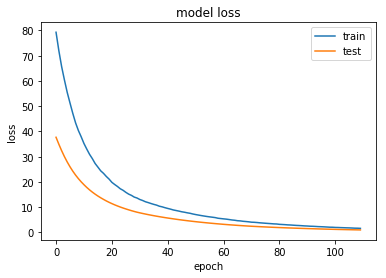

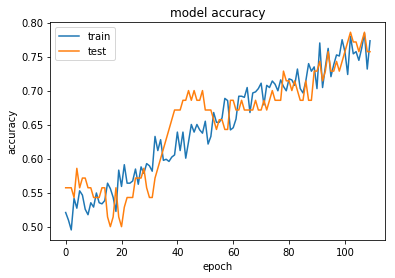

In [8]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

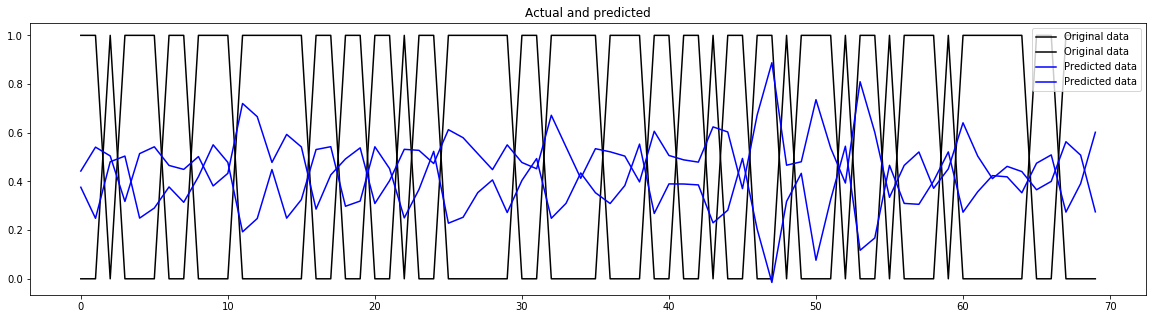

In [9]:
pred = model.predict(np.array(X_test)) 
original = Y_test 
predicted = pred  
plt.figure(figsize=(20, 5))
plt.plot(original, color='black', label = 'Original data') 
plt.plot(predicted, color='blue', label = 'Predicted data') 
plt.legend(loc='best') 
plt.title('Actual and predicted') 
plt.show()